## MIDTERM BIG DATA DAN AI ##

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count, floor, round, avg, sqrt, pow, corr
from pyspark.sql.functions import min as sql_min, max as sql_max
from pyspark.ml.feature import VectorAssembler, StandardScaler
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns





load data

In [5]:
os.environ["JAVA_HOME"] = "C:\\Program Files\\Java\\jdk-17"

spark = SparkSession.builder \
    .appName("NYC Taxi Fare - robust") \
    .config("spark.driver.memory", "4g") \
    .config("spark.executor.memory", "4g") \
    .config("spark.sql.shuffle.partitions", "8") \
    .config("spark.rpc.askTimeout", "600s") \
    .config("spark.network.timeout", "600s") \
    .config("spark.executor.heartbeatInterval", "60s") \
    .getOrCreate()

train_path = "train.csv"
test_path = "test.csv"

train_df = spark.read.csv(train_path, header=True, inferSchema=True)
test_df = spark.read.csv(test_path, header=True, inferSchema=True)

EDA

In [6]:
train_df.show()
train_df.printSchema()

+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|        4.5|2009-06-16 00:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1|
|2010-01-05 16:52:16|       16.9|2010-01-05 23:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1|
|2011-08-18 00:35:00|        5.7|2011-08-18 07:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|
|2012-04-21 04:30:42|        7.7|2012-04-21 11:30:42|       -73.98713|      40.733143|       -73.991567|       40.758092|              1|
|2010-03-09 07:51:00|        5.3|2

In [7]:
train_df.describe().show()


+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|summary|       fare_amount|  pickup_longitude|  pickup_latitude| dropoff_longitude|  dropoff_latitude|   passenger_count|
+-------+------------------+------------------+-----------------+------------------+------------------+------------------+
|  count|          55423856|          55423856|         55423856|          55423480|          55423480|          55423856|
|   mean|11.345045601663852|-72.50968444358729| 39.9197917868882|-72.51120972971809|39.920681444828844|1.6853799201556816|
| stddev|  20.7108321982325| 12.84888338140265|9.642353041994934|12.782196517830771| 9.633345796415124|1.3276643570959683|
|    min|            -300.0|      -3442.059565|     -3492.263768|      -3442.024565|      -3547.886698|                 0|
|    max|          93963.36|       3457.625683|      3408.789565|        3457.62235|       3537.132528|               208|
+-------+-------

data cleaning

In [4]:
from pyspark.sql.types import DoubleType, FloatType

exprs = []
for f in train_df.schema:
    name = f.name
    dtype = f.dataType
    if isinstance(dtype, (DoubleType, FloatType)):
        # untuk float/double cek isnan() + isNull()
        exprs.append(count(when(isnan(col(name)) | col(name).isNull(), name)).alias(name))
    else:
        # untuk tipe lain cukup cek isNull()
        exprs.append(count(when(col(name).isNull(), name)).alias(name))

train_df.select(exprs).show(truncate=False)


+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|key|fare_amount|pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+
|0  |0          |0              |0               |0              |376              |376             |0              |
+---+-----------+---------------+----------------+---------------+-----------------+----------------+---------------+



penghapusan data dengan batasan atau penghapusan data outlier

In [8]:
from pyspark.sql import DataFrame

def clean_taxi_df(df: DataFrame, is_train: bool = True) -> DataFrame:
    
    df_clean = df

    # 1) Drop rows where dropoff coords kosong (karena kita butuh dropoff untuk jarak)
    df_clean = df_clean.dropna(subset=["dropoff_longitude", "dropoff_latitude"])

    # 2) Jika kolom fare_amount ada dan kita sedang membersihkan train set, filter nilai tidak masuk akal
    if is_train and "fare_amount" in df_clean.columns:
        # cast aman bila perlu (kalau tipe string), gunakan cast(double) bila perlu
        # namun inferSchema=True biasanya sudah membuatnya double
        df_clean = df_clean.filter(
            (col("fare_amount").isNotNull()) &
            (col("fare_amount") > 0) &
            (col("fare_amount") < 500)    # threshold realistis untuk NYC in-city taxi
        )

    # 3) Filter koordinat ke rentang wajar untuk NYC
    # NYC roughly long: -75 .. -72, lat: 40 .. 42
    df_clean = df_clean.filter(
        (col("pickup_longitude").between(-75, -72)) &
        (col("dropoff_longitude").between(-75, -72)) &
        (col("pickup_latitude").between(40, 42)) &
        (col("dropoff_latitude").between(40, 42))
    )

    # 4) Filter passenger_count realistis
    # kadang ada 0 atau angka sangat besar; ambil 1..6
    if "passenger_count" in df_clean.columns:
        df_clean = df_clean.filter((col("passenger_count") >= 1) & (col("passenger_count") <= 6))

    return df_clean

# Tampilkan jumlah baris sebelum cleaning
print("Train sebelum:", train_df.count())
print("Test sebelum :", test_df.count())

# Jalankan cleaning
train_clean = clean_taxi_df(train_df, is_train=True)
test_clean  = clean_taxi_df(test_df, is_train=("fare_amount" in test_df.columns))

# Tampilkan jumlah baris setelah cleaning
print("Train sesudah:", train_clean.count())
print("Test sesudah :", test_clean.count())

# Tampilkan beberapa baris sampel untuk verifikasi
print("detelah dilakukan cleaning")
train_clean.show(5, truncate=False)
print("detelah dilakukan cleaning")
test_clean.show(5, truncate=False)




Train sebelum: 55423856
Test sebelum : 9914
Train sesudah: 54063034
Test sesudah : 9914
detelah dilakukan cleaning
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|key                |fare_amount|pickup_datetime    |pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+
|2009-06-15 17:26:21|4.5        |2009-06-16 00:26:21|-73.844311      |40.721319      |-73.84161        |40.712278       |1              |
|2010-01-05 16:52:16|16.9       |2010-01-05 23:52:16|-74.016048      |40.711303      |-73.979268       |40.782004       |1              |
|2011-08-18 00:35:00|5.7        |2011-08-18 07:35:00|-73.982738      |40.76127       |-73.991242       |40.750562       |2              |
|2012-04-21 04:30:42|7.7        |2012-04-21 11:30:42|-73.

penambahan fitur disctance di data train

In [9]:
from pyspark.sql import functions as F

# Radius bumi dalam kilometer
R = 6371.0

# Konversi ke radian
train_clean = train_clean.withColumn("pickup_lat_rad", F.radians(F.col("pickup_latitude"))) \
    .withColumn("pickup_lon_rad", F.radians(F.col("pickup_longitude"))) \
    .withColumn("drop_lat_rad", F.radians(F.col("dropoff_latitude"))) \
    .withColumn("drop_lon_rad", F.radians(F.col("dropoff_longitude")))

# Delta
train_clean = train_clean.withColumn("delta_lat", F.col("drop_lat_rad") - F.col("pickup_lat_rad")) \
    .withColumn("delta_lon", F.col("drop_lon_rad") - F.col("pickup_lon_rad"))

# Haversine formula
train_clean = train_clean.withColumn(
    "a",
    F.pow(F.sin(F.col("delta_lat") / 2), 2) +
    F.cos(F.col("pickup_lat_rad")) * F.cos(F.col("drop_lat_rad")) *
    F.pow(F.sin(F.col("delta_lon") / 2), 2)
).withColumn(
    "c",
    2 * F.atan2(F.sqrt(F.col("a")), F.sqrt(1 - F.col("a")))
).withColumn(
    "distance_km",
    R * F.col("c")
)

# Bersihkan kolom sementara biar tidak berat
train_clean = train_clean.drop("pickup_lat_rad", "pickup_lon_rad",
                               "drop_lat_rad", "drop_lon_rad",
                               "delta_lat", "delta_lon", "a", "c")

train_clean.show(10)


+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+------------------+
|                key|fare_amount|    pickup_datetime|pickup_longitude|pickup_latitude|dropoff_longitude|dropoff_latitude|passenger_count|       distance_km|
+-------------------+-----------+-------------------+----------------+---------------+-----------------+----------------+---------------+------------------+
|2009-06-15 17:26:21|        4.5|2009-06-16 00:26:21|      -73.844311|      40.721319|        -73.84161|       40.712278|              1| 1.030763935049508|
|2010-01-05 16:52:16|       16.9|2010-01-05 23:52:16|      -74.016048|      40.711303|       -73.979268|       40.782004|              1| 8.450133595805992|
|2011-08-18 00:35:00|        5.7|2011-08-18 07:35:00|      -73.982738|       40.76127|       -73.991242|       40.750562|              2|1.3895252257697308|
|2012-04-21 04:30:42|        7.7|2012-04-21 11:30:42|     

visualisasi data

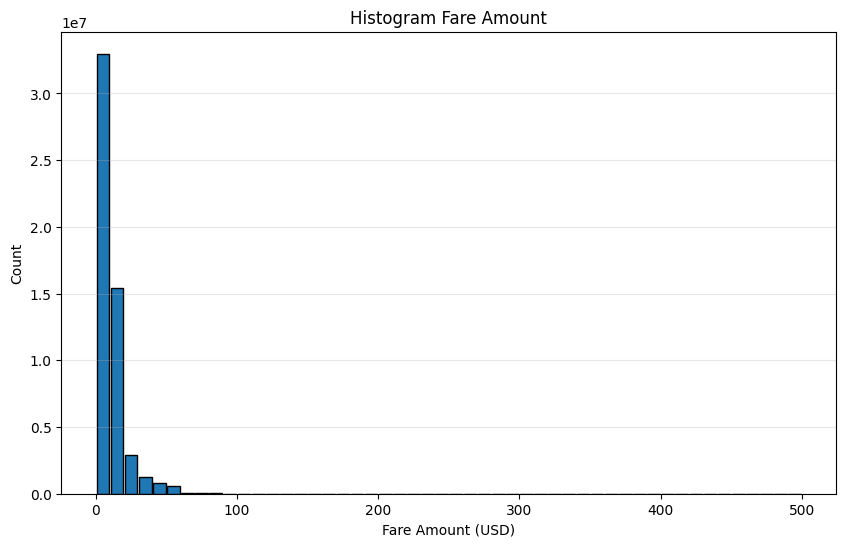

In [11]:
# batas visualisasi (pakai batas cleaningmu)
lower_bound = 0.0
upper_bound = 500.0
num_bins = 50
width = (upper_bound - lower_bound) / num_bins

# 1) Filter data sesuai bounds (ini sudah cleaning, tapi masih pastikan)
df_bins = train_clean.select("fare_amount") \
    .filter((col("fare_amount").isNotNull()) & (col("fare_amount") >= lower_bound) & (col("fare_amount") <= upper_bound))

# 2) Hitung index bin sebagai integer 0..num_bins-1
# floor((fare - lower)/width), lalu clip agar bin==num_bins -> num_bins-1
df_bins = df_bins.withColumn(
    "bin",
    when(
        (col("fare_amount") == upper_bound),
        num_bins - 1
    ).otherwise(
        floor((col("fare_amount") - lower_bound) / width).cast("integer")
    )
)

# 3) Group by bin dan count
hist_df = df_bins.groupBy("bin").agg(count("*").alias("count")).orderBy("bin")

# 4) Collect hasil (kecil) ke driver
hist = hist_df.collect()
# buat arrays lengkap (jika ada bin yang kosong, isi 0)
counts = [0] * num_bins
for row in hist:
    idx = int(row["bin"])
    counts[idx] = row["count"]

# 5) Buat bin edges/midpoints untuk plotting
bin_edges = np.linspace(lower_bound, upper_bound, num_bins + 1)
midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2.0
width_plot = bin_edges[1] - bin_edges[0]

# 6) Plot
plt.figure(figsize=(10,6))
plt.bar(midpoints, counts, width=width_plot*0.9, edgecolor="black")
plt.title(f"Histogram Fare Amount")
plt.xlabel("Fare Amount (USD)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


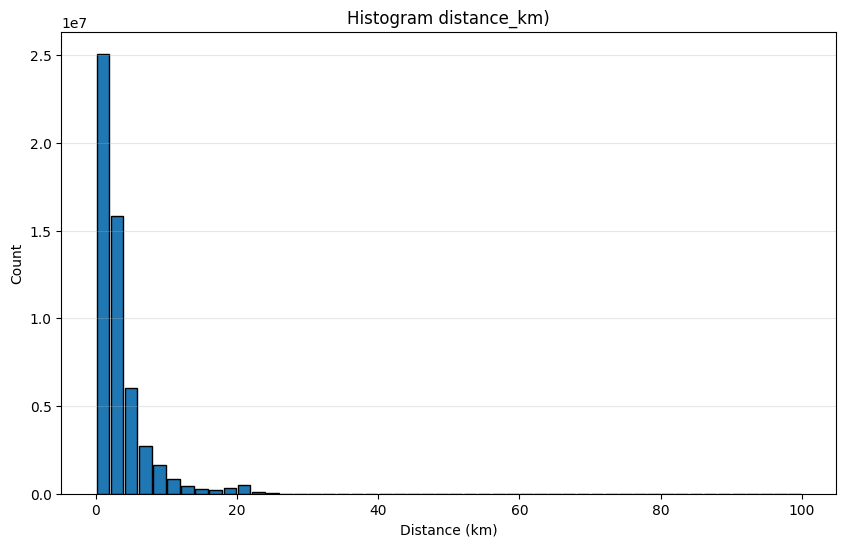

In [12]:
# Parameter histogram
lower_bound = 0.0       # minimal jarak yang ingin diplot
upper_bound = 100.0     # batas atas visualisasi (ubah sesuai kebutuhan)
num_bins = 50
width = (upper_bound - lower_bound) / num_bins

# Pastikan kolom distance_km ada dan nilai tidak null
df_bins = train_clean.select("distance_km").filter(col("distance_km").isNotNull())

# Batasi ke range yang diinginkan supaya bin terkontrol
df_bins = df_bins.filter((col("distance_km") >= lower_bound) & (col("distance_km") <= upper_bound))

# Hitung index bin: floor((x - lower)/width); pastikan nilai tepat pada upper_bound masuk bin terakhir
df_bins = df_bins.withColumn(
    "bin",
    when(col("distance_km") == upper_bound, num_bins - 1)
    .otherwise(floor((col("distance_km") - lower_bound) / width).cast("integer"))
)

# Group by bin dan hitung
hist_df = df_bins.groupBy("bin").agg(count("*").alias("count")).orderBy("bin")

# Collect kecil (num_bins rows) ke driver
rows = hist_df.collect()
counts = [0] * num_bins
for r in rows:
    counts[int(r["bin"])] = r["count"]

# Siapkan plotting
bin_edges = np.linspace(lower_bound, upper_bound, num_bins + 1)
midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2.0
width_plot = bin_edges[1] - bin_edges[0]

# Plot
plt.figure(figsize=(10,6))
plt.bar(midpoints, counts, width=width_plot*0.9, edgecolor="black")
plt.title(f"Histogram distance_km)")
plt.xlabel("Distance (km)")
plt.ylabel("Count")
plt.grid(axis="y", alpha=0.3)
plt.show()


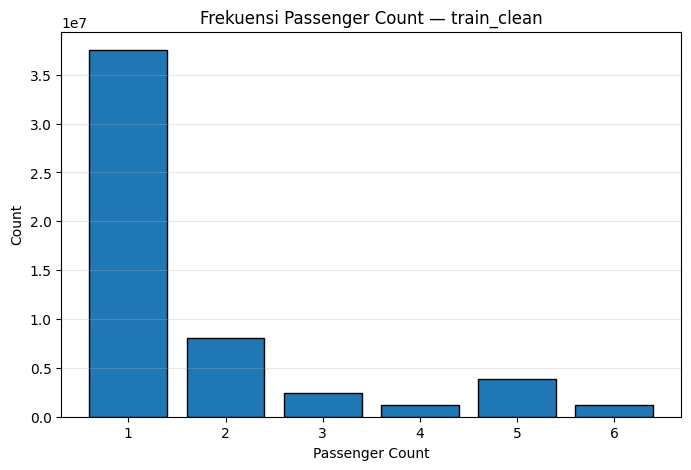

In [14]:
# Hitung frekuensi tiap passenger_count di train_clean
freq_df = train_clean.groupBy("passenger_count").agg(count("*").alias("count")).orderBy("passenger_count")

# Collect (karena jumlah baris kecil)
rows = freq_df.collect()

# Siapkan data untuk plotting
counts_map = {int(r["passenger_count"]): r["count"] for r in rows}

# Tentukan rentang x yang ingin ditampilkan (mis. 0..6 atau 1..6)
min_x = min(counts_map.keys())
max_x = max(counts_map.keys())
x_vals = list(range(min_x, max_x + 1))
y_vals = [counts_map.get(x, 0) for x in x_vals]

# Plot bar chart
plt.figure(figsize=(8,5))
plt.bar(x_vals, y_vals, edgecolor="black")
plt.xticks(x_vals)
plt.xlabel("Passenger Count")
plt.ylabel("Count")
plt.title("Frekuensi Passenger Count — train_clean")
plt.grid(axis="y", alpha=0.3)
plt.show()


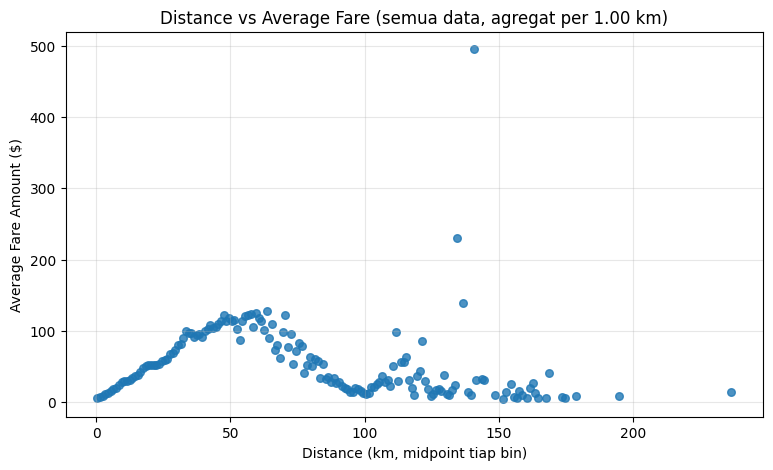

In [15]:
# Pilih nama kolom distance yang kamu punya: "distance_km" atau "distance"
dist_col = "distance_km"   # ganti "distance" kalau itu namanya

# 1) Buat bin per 1 km (ubah 0.5 untuk lebih detail)
bin_width = 1.0
# buat kolom bin index sebagai integer = floor(distance / bin_width)
binned = train_clean.filter(col(dist_col).isNotNull() & (col(dist_col) > 0)) \
    .withColumn("dist_bin", floor(col(dist_col) / bin_width))

# 2) Hitung rata-rata fare per bin
agg_df = binned.groupBy("dist_bin").agg(avg("fare_amount").alias("avg_fare"), 
                                        ).orderBy("dist_bin")

# 3) Ambil hasil kecil ke driver
rows = agg_df.collect()
bins = [int(r["dist_bin"]) for r in rows]
avg_fares = [float(r["avg_fare"]) for r in rows]

# 4) Siapkan x sebagai midpoint bin (km)
midpoints = [(b + 0.5)*bin_width for b in bins]  # midpoint mis: bin 0 => 0.5 km

# 5) Plot scatter (agregat)
plt.figure(figsize=(9,5))
plt.scatter(midpoints, avg_fares, s=30, alpha=0.8)
plt.xlabel("Distance (km, midpoint tiap bin)")
plt.ylabel("Average Fare Amount ($)")
plt.title("Distance vs Average Fare (semua data, agregat per {:.2f} km)".format(bin_width))
plt.grid(alpha=0.3)
plt.show()


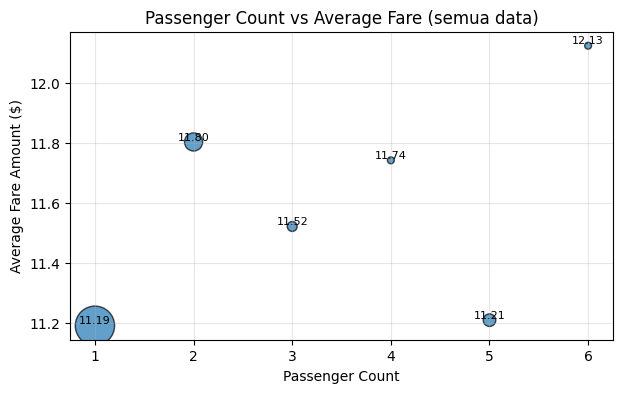

In [16]:
# 1) Hitung rata-rata fare & frekuensi per passenger_count
pc_agg = train_clean.groupBy("passenger_count") \
    .agg(
        avg("fare_amount").alias("avg_fare"),
        count("*").alias("n")
    ).orderBy("passenger_count")

rows = pc_agg.collect()
pcs = [int(r["passenger_count"]) for r in rows]
avg_fares_pc = [float(r["avg_fare"]) for r in rows]
counts_pc = [int(r["n"]) for r in rows]

# 2) Plot scatter (size titik proporsional ke frekuensi)
plt.figure(figsize=(7,4))
sizes = [max(20, n / max(counts_pc) * 800) for n in counts_pc]  # scale dot size
plt.scatter(pcs, avg_fares_pc, s=sizes, alpha=0.7, edgecolor="black")
for x,y in zip(pcs, avg_fares_pc):
    plt.text(x, y, f"{y:.2f}", va="bottom", ha="center", fontsize=8)
plt.xticks(pcs)
plt.xlabel("Passenger Count")
plt.ylabel("Average Fare Amount ($)")
plt.title("Passenger Count vs Average Fare (semua data)")
plt.grid(alpha=0.3)
plt.show()


In [17]:
# korelasi distance_km vs fare_amount
train_clean.select(corr(dist_col, "fare_amount")).show()

# korelasi passenger_count vs fare_amount
train_clean.select(corr("passenger_count", "fare_amount")).show()


+------------------------------+
|corr(distance_km, fare_amount)|
+------------------------------+
|             0.818931230938017|
+------------------------------+

+----------------------------------+
|corr(passenger_count, fare_amount)|
+----------------------------------+
|              0.012976119270569778|
+----------------------------------+



transformasi data train

In [18]:
#Gabungkan kedua fitur ke dalam 1 kolom vektor
assembler = VectorAssembler(
    inputCols=["distance_km", "passenger_count"],
    outputCol="features_raw"
)

# Terapkan assembler ke data train_clean
assembled_df = assembler.transform(train_clean)

#Lakukan standard scaling (mean = 0, std = 1)
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_scaled",
    withMean=True,  # agar hasilnya terpusat di 0
    withStd=True    # agar memiliki deviasi standar 1
)

# Fit scaler ke data dan transformasi
scaler_model = scaler.fit(assembled_df)
scaled_df = scaler_model.transform(assembled_df)

#Tampilkan hasil scaling (2 kolom fitur baru)
scaled_df.select("distance_km", "passenger_count", "features_scaled").show(10, truncate=False)


+------------------+---------------+------------------------------------------+
|distance_km       |passenger_count|features_scaled                           |
+------------------+---------------+------------------------------------------+
|1.030763935049508 |1              |[-0.6076929644370769,-0.5288129486838183] |
|8.450133595805992 |1              |[1.3529741991434254,-0.5288129486838183]  |
|1.3895252257697308|2              |[-0.5128855192710169,0.23632495578656182] |
|2.799270239983641 |1              |[-0.14034163956510692,-0.5288129486838183]|
|1.9991567879963377|1              |[-0.3517822664890118,-0.5288129486838183] |
|3.7872390847819903|1              |[0.12074227473054222,-0.5288129486838183] |
|1.5558066593500526|1              |[-0.4689434377140794,-0.5288129486838183] |
|4.155444291845812 |1              |[0.21804540046208662,-0.5288129486838183] |
|1.253231512725298 |1              |[-0.5489029466250054,-0.5288129486838183] |
|2.8496267961070503|2              |[-0.

pembagian data untuk mengecek keakuratan

In [19]:
# Bagi data menjadi train (80%) dan validation (20%)
train_data, test_data = scaled_df.randomSplit([0.8, 0.2], seed=42)

print(f"Jumlah data train : {train_data.count()}")
print(f"Jumlah data validasi : {test_data.count()}")


Jumlah data train : 43248240
Jumlah data validasi : 10814794


pembuatan model dan training dengan model linear regression

In [20]:
from pyspark.ml.regression import LinearRegression

# Inisialisasi model regresi linear
lr = LinearRegression(
    featuresCol="features_scaled", 
    labelCol="fare_amount"
)

# Latih model
lr_model = lr.fit(train_data)


evaluasi model dengan data test

In [21]:
from pyspark.ml.evaluation import RegressionEvaluator

test_pred = lr_model.transform(test_data)

evaluator_rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")
evaluator_r2   = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2")
evaluator_mae  = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae")

rmse = evaluator_rmse.evaluate(test_pred)
r2   = evaluator_r2.evaluate(test_pred)
mae  = evaluator_mae.evaluate(test_pred)

print(f"Validation RMSE: {rmse:.4f}")
print(f"Validation MAE : {mae:.4f}")
print(f"Validation R2  : {r2:.4f}")

# 4) Tampilkan contoh prediksi
test_pred.select("fare_amount", "prediction").show(10, truncate=False)

Validation RMSE: 5.5547
Validation MAE : 2.5487
Validation R2  : 0.6710
+-----------+------------------+
|fare_amount|prediction        |
+-----------+------------------+
|29.4       |36.21913710422086 |
|5.0        |5.9523110132916965|
|16.5       |17.32571554173421 |
|5.4        |6.993719230106692 |
|11.3       |13.849418808794054|
|9.0        |11.381728723588951|
|4.2        |6.349289134531077 |
|6.6        |8.211895743839047 |
|10.2       |12.213702317805412|
|9.7        |9.621286998991286 |
+-----------+------------------+
only showing top 10 rows


In [ ]:
# Hyperparameter tuning dengan TrainValidationSplit (cepat dibanding CV)
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder
from pyspark.ml.evaluation import RegressionEvaluator
import time

# 1) Inisialisasi estimator
lr = LinearRegression(featuresCol="features_scaled", labelCol="fare_amount")

# 2) Susun grid hyperparameter (ubah range jika mau eksperimen lebih luas)
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.001, 0.01, 0.1])
             .addGrid(lr.elasticNetParam, [0.0, 0.25, 0.5, 1.0])  # 0=ridge, 1=lasso
             .addGrid(lr.maxIter, [50, 100])
             .build())

# 3) Evaluator (kita pakai RMSE untuk memilih best model)
evaluator = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse")

# 4) TrainValidationSplit: lebih cepat dari CV, gunakan trainRatio internal (mis. 0.8)
tvs = TrainValidationSplit(estimator=lr,
                           estimatorParamMaps=paramGrid,
                           evaluator=evaluator,
                           trainRatio=0.8,
                           parallelism=4)   # ubah sesuai jumlah core yang tersedia
# 5) Jalankan tuning (ukur waktu)
start = time.time()
tvs_model = tvs.fit(scaled_df)
elapsed = time.time() - start
print(f"Tuning selesai dalam {elapsed/60:.2f} menit")

# 7) Ambil best model dan parameternya
best_model = tvs_model.bestModel
# akses parameter lewat API Java (terpercaya)
best_reg = best_model._java_obj.getRegParam()
best_enet = best_model._java_obj.getElasticNetParam()
best_iter = best_model._java_obj.getMaxIter()
print("Best params found:")
print(f"  regParam = {best_reg}")
print(f"  elasticNetParam = {best_enet}")
print(f"  maxIter = {best_iter}")

# 9) Evaluasi best model pada scaled_test
test_pred = best_model.transform(scaled_test)

# hitung metrik (RMSE, MAE, MSE, R2)
rmse = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="rmse").evaluate(test_pred)
mae  = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mae").evaluate(test_pred)
mse  = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="mse").evaluate(test_pred)
r2   = RegressionEvaluator(labelCol="fare_amount", predictionCol="prediction", metricName="r2").evaluate(test_pred)

print("\n=== Evaluation on scaled_test ===")
print(f"RMSE: {rmse:.4f}")
print(f"MAE : {mae:.4f}")
print(f"MSE : {mse:.4f}")
print(f"R2  : {r2:.4f}")

# 10) Tampilkan contoh prediksi
test_pred.select("fare_amount", "prediction").show(10, truncate=False)

